# The Point of This Notebook

Machine learning is focused on making accurate predictions. But it is **decisions** that affect the world. 

Predictions are useful to the extent they help us make better decisions, but good decision-making requires an optimization step which is frequently overlooked.

Friends working in data science have told me how their companies' huge wins when switching from oversimple heuristics to machine learning models for prediction. But in most cases I've heard, these predictions are converted into actions in a naive way that still leaves a lot of money on the table.

There are optimization techniques to improve decision-making in the same way machine learning has improved predictions, and these decision optimization techniques can have payoffs in the next few years of similar magnitude to what ML is providing today.

# Examples

I'll briefly describe two example applications before working through one problem in more depth.

### Airline Pricing
Airlines use machine learning models to help set ticket prices. A model predicts how many tickets they can sell each day for each upcoming flight for each candidate price. In addition to price, the models consider seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model wouldn't guarantee efficient price setting. 

For example, consider a flight happening in 100 days which currently has 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose? 

The predictive model alone can't tell you the right choice in this type of dynamic optimization problem. The dynamic optimization is especially important in the likely circumstance that competitors consider your price when making their pricing decisions, the same way you consider their prices.

Airlines use heuristics (e.g. a timetable of how many tickets to sell at pre-specified periods before the flight, or a rule of thumb to sell up to a pre-specified demand elasticity.) These rules of thumb allow them to convert predictions into decisions. But the heuristics seem oversimple, much like the rules of thumb they previously used to predict sales at each time.

### Grocery Store Logistics
A grocery chain ran a [predictive modeling competition on Kaggle](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) to improve demand forecasts. Better forecasts allow them to purchase an amount of each food that is closer to what will actually sold. However, purchasing an optimal amount from their wholesaler is still an optimization problem.

If a model says you will likely sell 1000 pounds of broccoli in the next week, how much should you purchase from your wholesaler. If you purchase exactly 1000 pounds, there is a reasonable chance your model will have underestimated. This causes a stockout, losing profitable sales and disappointing customers.  Similarly, if the model overestimates sales, some broccoli will rot. Unless you know the model to be correct every time, you face a tradeoff.  The optimal decision depends on factors like
- Markup rate on each sale
- Cost of storage
- Spoilage rate
- Value of ensuring customers find the items they want
- Ability to mark down item midweek to ensure it is all sold
- etc.

Ideally, you'd have estimates for each of these factors for each food. This would allow you to do a formal optimization. In practice, grocery store managers likely guess at how to make these tradeoffs, much as they previously guessed at how much of each food they would sell.


I won't belabor the list of examples, because **it is the rule rather than the exception for business decisions to depend on optimization with many moving parts. If this sounds contentious, I believe it's because we've acquired the habit of slicing prediction problems out of their larger business contexts so we can apply machine learning.**


# Detailed Example
The code example below addresses the Airline Pricing problem. 

I simulate a data generating process for how the market works, rather than using real data. This decision relegates our example to being toy problem, but it helps illustrate the benefits of formal optimization because we can quickly see how our resulting pricing strategy performs in the original data generating environment.

## Market Set-Up
For illustrative simplicity, this example considers a market with only two airlines. We train an agent to set prices for Jetblue; the competitor, whose prices we cannot control, is called Delta. 

The airline don't know their competitor's pricing policy. Further, the quantity of tickets sold is determined by a market mechanism which the airlines do not know (though they can use a model to predict tickets sales as a function of prices and other features). 

All information the firms don't see is stored in a `CompetitiveConditions` object. `CompetitiveConditions` can be created from the true data generating processes, or from a predictive model that approximates those processes. So, when optimizing Jetblue's pricing policy, we use the model-based environment to optimize the policy.

All environments, both model-based and those using the data generating process, are stored as `Market` objects. The `Market` object is a subclass of an OpenAI gym enviornment. This allows us to use conventional reinforcement learning algorithms for optimization. Moreover, using a common API for the "true" market and for model-based markets makes it easy to see how a pricing policy optimized from a model-based market performs in the true market.

Markets are built from a `CompetitiveConditions` object as well as some variables that are completely known to airlines. Nothing surprising is included as "common knowledge." Common knowledge variables are
- the number of seats per flight (`SEATS_PER_FLIGHT`)
- the number of days until that flight takes off (`SALES_WINDOW_LENGTH`)
- some trivially obvious dynamics (e.g. the number of seats they will have available to sell tomorrow is the difference between what they have available today and what they sell today.)


The details of how the market's quantity setting mechanism are not critical for understanding this notebook.
*You can safely treat the quantity setting mechanism as a black box (as the airlines do).* However, it is described in the remainder of this paragraph. Some number of customers (`POTENTIAL_CUSTOMERS_PER_DAY`) come to a website each day.  The customers' average willingness to pay for a flight on that day `demand_level`. The `demand level` on any given day is chosen from a distribution `uniform(0, MAX_DEMAND_LEVEL)`.  Each airline receives a signal about `demand_level` on that day, and the signal is the `demand_level` plus some noise that is distributed `N(0, DEMAND_SIGNAL_NOISINESS)`. This demand signal might represent a prediction of demand from a model considering seasonality, macroeconomics, etc. Additionally, each customer has idiosyncratic preferences, so their willingness to pay for a ticket on any given airline is `demand_level + customer_preference` where `customer_preference` is distributed `N(0, CUSTOMER_LEVEL_RANDOMNESS)`.  The customer considers the price for each of the two airlines and purchases a ticket from the airline that gives them the highest consumer surplus (their personal willingness to pay minus for a ticket on that airline minus the cost of a ticket on that airline).  If the customer's consumer surplus for both airlines is negative, they do not buy a ticket.


# Imports and Set Up Parameters of "Real" Market

In [1]:
import altair as alt
import numpy as np
import pandas as pd

from keras_models import get_keras_model, prep_data_for_keras_model
from market import Market
from market_conditions import CompetitiveConditions
from model_testing import run_env
from pymc_models import WrappedPymcModel
from true_dgp import get_true_qty_demanded_fn


# Constants hidden from airlines
CUSTOMER_LEVEL_RANDOMNESS = 20
DEMAND_SIGNAL_NOISINESS = 10
MAX_DEMAND_LEVEL = 500
POTENTIAL_CUSTOMERS_PER_DAY = 20

# Constants known to airlines
SEATS_PER_FLIGHT = 200
SALES_WINDOW_LENGTH = 100


I guessed a reasonable pricing function (with some trial and error), and this example uses this as the underlying price function used to create the real data.

In [2]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, few seats are available, or you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    return max(my_demand_signal, days_before_flight) +  1.5 * days_before_flight - my_seats_avail - 20 * int(competitor_full)


# Run Real Market

Airlines have historical data they can use to build a model. Here, we run the "real" environment to create 200 flights worth of data.

In [3]:
real_market_conditions = CompetitiveConditions(delta_price_fn = simple_price_fn, 
                                               qty_fn=get_true_qty_demanded_fn(POTENTIAL_CUSTOMERS_PER_DAY, CUSTOMER_LEVEL_RANDOMNESS))
real_market = Market(real_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=500)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=100)


# Fit Model

We fit a model that predicts Delta's price and the quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)

The model is available in `keras_models`.  It's nothing sophisticated.

In [4]:
train_x, train_y = prep_data_for_keras_model(train_data)
val_x, val_y = prep_data_for_keras_model(val_data)
keras_model = get_keras_model(train_x, train_y, val_x, val_y)

# Set Up Model-Based Market Simulator

Now create a market based not on the true data generating processes (which the firms don't know), but instead using their predictive model.

Print out the predicted profits from using Jetblue's current pricing function in the training, val and simulator data.  If the model were perfect, the profits in the simulator would be extremely close to the profits in the training and validation data.

Note that there's a lot of dynamics from outside any ML model being used to estimate profits, since the firms are setting prices day-after-day.

In [5]:
sim_market_conditions = CompetitiveConditions(keras_model=keras_model)
sim_market = Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)

simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=100)

print("Mean profits in training data: {} \n"
      "Mean profits in val data: {} \n"
      "Mean profits in sim data: {} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

Mean profits in training data: 55793.022 
Mean profits in val data: 56206.41 
Mean profits in sim data: 56748.035 



# Experiment With Different Pricing Strategies

Now that we have a simulator, we could apply an arbitrary reinforcement learning algorithm to create a better pricing policy. While we use the simulator for learning, our goal is to have a pricing policy that increases profits in the real environment.

For simplicity, we start with something simpler than an arbitrary reinfrocement learning model. That is, we have a function `pricing_fn_maker` that returns the previously used pricing function by some constant. This would conceivably correct for systematic overpricing or underpricing in the original pricing function.

   base_price_mult  mean_predicted_rev  mean_actual_rev
0             0.50          28554.2475      32274.55250
1             0.75          49210.2600      53294.98875
2             1.00          57178.1000      56008.15500
3             1.50          13932.0450      14506.62000
4             2.00           5631.4200       7537.41000


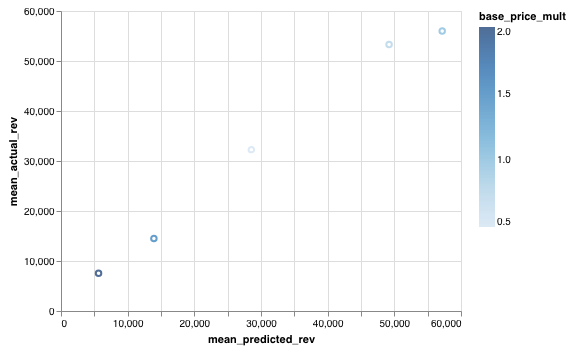

In [6]:
def pricing_fn_maker(baseline_price_multiplier):
    def new_price_fn(*args, **kwargs):
        return baseline_price_multiplier * simple_price_fn(*args, **kwargs)
    return new_price_fn

alternative_pricing_profits = []
alternative_pricing_scenario_details = {}

for price_mult in [0.5, 0.75, 1, 1.5, 2]:
    new_price_fn = pricing_fn_maker(price_mult)
    pred_profits, pred_data = run_env(sim_market, new_price_fn, n_times=100)
    actual_profits, actual_data = run_env(real_market, new_price_fn, n_times=100)
    alternative_pricing_profits.append((price_mult, pred_profits.mean(), actual_profits.mean()))
    alternative_pricing_scenario_details[price_mult] = {'pred': pred_data,
                                                        'actual': actual_data}

price_comparison = pd.DataFrame(alternative_pricing_profits, 
                                columns=['base_price_mult', 'mean_predicted_rev', 'mean_actual_rev'])

print(price_comparison)

alt.Chart(price_comparison).mark_point().encode(
    x='mean_predicted_rev',
    y='mean_actual_rev',
    color='base_price_mult',
    tooltip='base_price_mult')

The results vary from run-to-run (primarily due to variation in the trained model).

Across all runs, the existing pricing policy is better in the real environment than any alternatives being considered. 

Profits in the simulator increase monotonically in some runs. This happens because the model does a poor job estimating how Jetblue Price impacts total seats sold.

Here is a cross-tab of total seats sold across 100 flights vs the pricing multiplier

In [7]:
pd.DataFrame([{'price_multiplier': i, 
               'total_seats_sold': alternative_pricing_scenario_details[i]['pred'].jetblue_seats_sold.sum()}
                      for i in alternative_pricing_scenario_details.keys()])

,price_multiplier,total_seats_sold
0,0.50,20000.0
1,0.75,20000.0
2,1.00,19610.0
3,1.50,13143.0
4,2.00,11054.0


Below, I show predicted quantities sold in a given day for various candidate jetblue prices (holding the number of days until the flight constant at 100, and Jetblue's demand signal constant at 100.)

These results look sensible when the optimization results were sensible, but they sometimes show upward sloping demand for Jetblue.

In [8]:
days_before_flight = jb_demand_signal = 100
pred_outcomes_diff_jb_prices = []
for jb_price in [0, 25, 50, 100, 150, 200, 250, 300, 400, 500]:
    # Some extra munging here do to messiness associated with multi-input / multi-output model.
    # each input fed in as separate array to facilitate hiding jetblue_price from prediction of delta_price
    prediction = keras_model.predict([np.array(feat,).reshape([1,1]) for feat in [days_before_flight, jb_demand_signal, jb_price]])
    delta_price, jb_seats_sold, delta_seats_sold = [max(i[0][0], 0) for i in prediction]
    pred_outcomes_diff_jb_prices.append({'jb_price': jb_price,
                                         'delta_price': delta_price,
                                         'jetblue_seats_sold': jb_seats_sold,
                                         'delta_seats_sold': delta_seats_sold})
pd.DataFrame(pred_outcomes_diff_jb_prices).set_index(['jb_price'])

,delta_price,delta_seats_sold,jetblue_seats_sold
jb_price,,,
0,68.034958,6.054972,8.524861
25,68.034958,7.422913,7.005760
50,68.034958,6.199681,7.814866
100,68.034958,2.741606,7.073650
150,68.034958,2.566578,0.786602
200,68.034958,0.000000,0.000000
250,68.034958,0.000000,0.000000
300,68.034958,0.000000,0.000000
400,68.034958,0.000000,0.000000
